# Preprocessing data to csv / pandas format using Xarray
[xarray](http://xarray.pydata.org/en/stable/) is this awesome package for working with multidimensional data. The major benefit is the labelled axes, making code more readable.

In [1]:
# pip install xarray
# conda install xarray dask netCDF4 bottleneck

In [11]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [68]:
# change this to the path where you saved the data_kenya.nc file
data_dir = Path('/Users/tommylees/Downloads/')
path_to_nc = data_dir / 'data_kenya.nc'

## Open the data in xarray
- [Quick Overview of how to use xarray](http://xarray.pydata.org/en/stable/quick-overview.html)
- VCI stands for **Vegetation Condition Index**
- VCI is a standardised index between 0-100, where 100 is the MOST health vegetation observed, 0 is the least healthy.
- We have labelled dimensions of `lat: 45, lon: 35, time: 216`
- We have data for three variables `VCI3M, boku_VCI, modis_ndvi` we are only interested in the `boku_VCI` 
- (the others are a three month rolling average `VCI3M`, and the underlying vegetation health data which the VCI is calculated from `modis_ndvi`)

In [4]:
# open in xarray and view the dataset
ds = xr.open_dataset(path_to_nc)
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 216)
Coordinates:
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2019-11-30
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 ...
    boku_VCI    (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...

### let's view a map of the data!
Xarray has some really helpful plotting tools - for example plotting latlons on a kind of map!

You can see Kenya below. The missing data is the Indian Ocean Coast in the SW. And Lake Turkana in the NE.

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geology.com/world/kenya-map.gif", width=400, height=400)

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


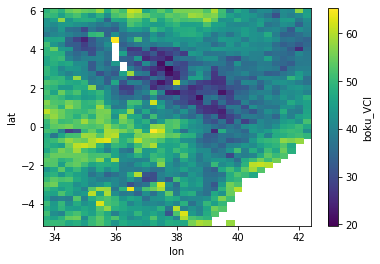

In [6]:
# Plot the MEAN VCI data (`boku_VCI`) as a map
ds['boku_VCI'].mean(dim='time').plot();

## We can easily convert to a pandas dataframe or numpy array
- Here we are going to select a 5x5 grid of the latlons, selecting the first 5 latlons (by index number = `ds.isel()`)

For numpy:
```
ds.values
```

**NOTE**: `to_dataframe()` function can be time consuming so try to select an area or one of the variables first!
For pandas:
```
ds.to_dataframe()
```

In [18]:
# convert 5x5 grid of lat lons to numpy
np_array =  ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).values

print("shape (times, lat, lon): ", np_array.shape)

shape (times, lat, lon):  (216, 5, 5)



#### For pandas notice our multi-index
- Because our data here is 3D (lat, lon, time) we have 3 indexes in the dataframe
- we can set these as columns using the `df.reset_index()` function. 
- then we have a pretty standard csv format

In [22]:
df = ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).to_dataframe()
df.head()

boku_VCI
time       lat lon             
2001-12-31 6.0 33.75  43.718593
               34.00  31.132075
               34.25  85.882353
               34.50  20.183486
               34.75  58.447489

# A more standard time series format

#### Let's turn each column into VCI for a given pixel (lat-lon pair)
- to do this we need to `.stack()` the lat lon dimensions to get a pixel dimension (2d -> 1d)
- this is unfortunately more involved but i guess this is kinda what you were interested in!

In [69]:
stacked = ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).stack(pixel=['lat', 'lon'])

# store the pixel latlon (is this useful?)
pixels = stacked.pixel.values
pixel_map = {i: pxl for i, pxl in enumerate(pixels)}
column_map  = {f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()}
times = [pd.to_datetime(t) for t in stacked.time.values]

stacked_df = pd.DataFrame(stacked.values, columns=[f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()], index=times)
stacked_df.to_csv(data_dir / 'vci_pixels.csv')
stacked_df.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
2001-12-31,43.718593,31.132075,85.882353,20.183486,58.447489,63.900415,72.123894,65.695793,87.570621,61.691542,...,41.538462,94.464945,77.238806,62.857143,6.666667e+01,60.080645,58.102767,37.549407,100.000000,1.000000e+02
2002-01-31,2.843602,16.078431,33.333333,78.169014,67.796610,56.603774,45.086705,24.409449,58.723404,64.541833,...,20.105820,66.666667,33.816425,30.687831,2.695312e+01,19.004525,11.956522,0.000000,62.886598,3.098592e+01
2002-02-28,34.337349,29.411765,1.973684,56.818182,33.854167,16.842105,21.052632,30.000000,47.651007,48.514851,...,10.389610,21.354167,16.176471,1.834862,-3.552714e-15,0.000000,9.411765,0.000000,14.388489,7.105427e-15
2002-03-31,50.000000,34.065934,23.602484,44.715447,20.138889,32.203390,18.461538,24.657534,21.551724,34.722222,...,20.270270,16.935484,21.875000,5.714286,-3.552714e-15,12.244898,13.559322,0.000000,0.000000,3.194444e+01
2002-04-30,54.945055,90.322581,43.930636,73.722628,75.949367,62.857143,76.282051,47.023810,66.197183,73.964497,...,50.310559,36.521739,71.005917,39.682540,2.315271e+01,79.545455,25.490196,3.773585,1.973684,7.608696e+00


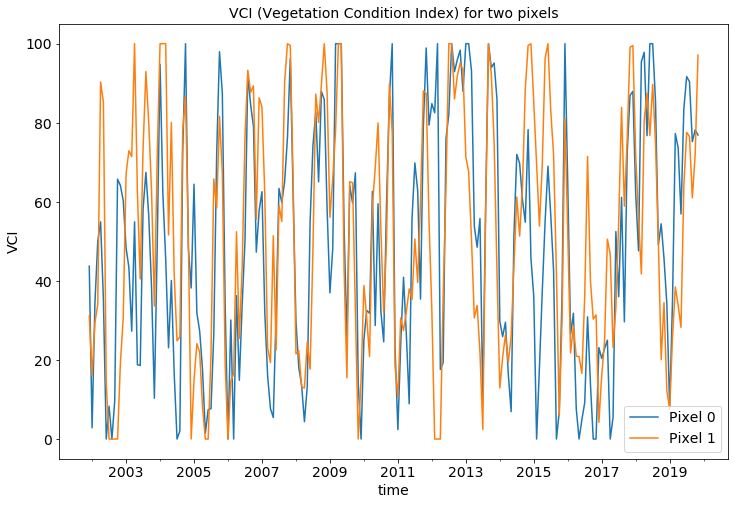

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
stacked_df[['VCI_0', 'VCI_1']].rename(columns={'VCI_0': 'Pixel 0', 'VCI_1': 'Pixel 1'}).plot(ax=ax)
ax.set_title('VCI (Vegetation Condition Index) for two pixels')
ax.set_xlabel('time')
ax.set_ylabel('VCI')

plt.legend(fontsize=14)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

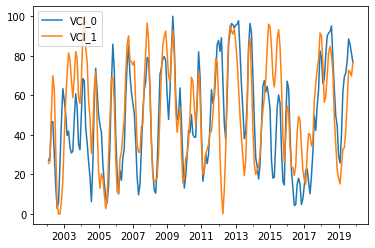

In [88]:
stacked_df.rolling(3).mean()[['VCI_0', 'VCI_1']].plot()